In [2]:
import os
import copy
import random
import pandas as pd
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms.functional as TF
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from PIL import Image


In [8]:

# Define the custom dataset class
class OvaryDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        categories = os.listdir(root_dir)
        for category in categories:
            category_path = os.path.join(root_dir, category)
            if os.path.isdir(category_path):
                label = 1 if category == 'infected' else 0  # Assign label 1 to 'infected' and 0 to 'notinfected'
                images = os.listdir(category_path)
                for image in images:
                    self.image_paths.append(os.path.join(category_path, image))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("L")  # Convert to grayscale

        if self.transform:
            image = self.transform(image)

        return image, label
        
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [9]:
class GenBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(GenBlock, self).__init__()
        
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        
        return self.dropout(self.relu(x))

class DisBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(DisBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        
        return self.dropout(self.relu(x))

In [10]:
class Generator(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super(Generator, self).__init__()
        
        self.inBlock = GenBlock(in_channels, mid_channels, kernel_size=4, stride=1, padding=0)  #4x4
        self.net = nn.Sequential(
            GenBlock(mid_channels+1, mid_channels//2, kernel_size=4, stride=2, padding=1),  #8x8
            GenBlock(mid_channels//2, mid_channels//4, kernel_size=4, stride=2, padding=1),  #16x16
            GenBlock(mid_channels//4, mid_channels//8, kernel_size=4, stride=2, padding=1),  #32x32
            GenBlock(mid_channels//8, mid_channels//16, kernel_size=4, stride=2, padding=1),  #64x64
            nn.ConvTranspose2d(mid_channels//16, out_channels, kernel_size=4, stride=2, padding=1),#128x128
            nn.Tanh())
        
        self.embedding = nn.Embedding(3, 50)
        self.linear = nn.Linear(50, 4*4)
        
    def forward(self, x, label):
        y = self.embedding(label)
        y = self.linear(y).view(-1,1,4,4)
        x = self.inBlock(x)
        x = torch.cat((x,y), dim=1)
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels, mid_channels):
        super(Discriminator, self).__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            DisBlock(mid_channels, mid_channels*2, 4, 2, 1),
            DisBlock(mid_channels*2, mid_channels*4, 4, 2, 1),
            DisBlock(mid_channels*4, mid_channels*8, 4, 2, 1),
            DisBlock(mid_channels*8, mid_channels*16, 4, 2, 1)
        )
        
        self.Slinear = nn.Linear(mid_channels*16*4*4, 1)  # Adjusted for the output size after downscaling
        self.Clinear = nn.Linear(mid_channels*16*4*4, 3)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.net(x)
        x = torch.flatten(x, start_dim=1)
        y1 = self.sigmoid(self.Slinear(x)).view(-1)
        y2 = self.softmax(self.Clinear(x))
        return y1, y2

def add_noise(inputs):
    noise = torch.randn_like(inputs)
    return inputs + noise

In [11]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
nz = 100
learning_rate = 0.002
betas = (0.5, 0.999)
num_epochs = 20
batch_size = 64

# Load the dataset
data_transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
])

train_data_path = 'grayscale_dataset/train'  # Specify the path to the train data folder
train_dataset = OvaryDataset(train_data_path, transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize models
GNet = Generator(nz, 1024, 1).to(device)  # Output channels set to 1 for grayscale images
GNet.apply(weights_init)
DNet = Discriminator(1, 32).to(device)  # Adjusted in_channels to 1 for grayscale images
DNet.apply(weights_init)

# Define loss functions and optimizers
criterion = nn.BCELoss()
classCriterion = nn.CrossEntropyLoss()
optimizerG = optim.Adam(GNet.parameters(), lr=learning_rate, betas=betas)
optimizerD = optim.Adam(DNet.parameters(), lr=learning_rate, betas=betas)

# Training loop
disc_loss = []
gen_loss = []
# Define directory to save generated images
save_dir = 'generated_images/'
# Create directory if it does not exist


Epoch [1/20], Step [1/31], D_loss: 3.6697, G_loss: 2.0788, D(x): 0.50, D(G(z)): 0.50
Epoch [2/20], Step [1/31], D_loss: 4.8008, G_loss: 2.1643, D(x): 0.22, D(G(z)): 0.23
Epoch [3/20], Step [1/31], D_loss: 4.7948, G_loss: 6.9400, D(x): 0.52, D(G(z)): 0.63
Epoch [4/20], Step [1/31], D_loss: 4.4743, G_loss: 4.1457, D(x): 0.84, D(G(z)): 0.86
Epoch [5/20], Step [1/31], D_loss: 3.4329, G_loss: 3.0765, D(x): 0.64, D(G(z)): 0.45
Epoch [6/20], Step [1/31], D_loss: 4.1140, G_loss: 3.5364, D(x): 0.78, D(G(z)): 0.75
Epoch [7/20], Step [1/31], D_loss: 3.2458, G_loss: 3.3726, D(x): 0.66, D(G(z)): 0.44
Epoch [8/20], Step [1/31], D_loss: 2.9092, G_loss: 3.2823, D(x): 0.68, D(G(z)): 0.37
Epoch [9/20], Step [1/31], D_loss: 4.0099, G_loss: 2.6001, D(x): 0.84, D(G(z)): 0.79
Epoch [10/20], Step [1/31], D_loss: 4.0750, G_loss: 3.7409, D(x): 0.48, D(G(z)): 0.38
Epoch [11/20], Step [1/31], D_loss: 4.2017, G_loss: 2.7211, D(x): 0.71, D(G(z)): 0.62
Epoch [12/20], Step [1/31], D_loss: 3.8506, G_loss: 3.3265, D(x

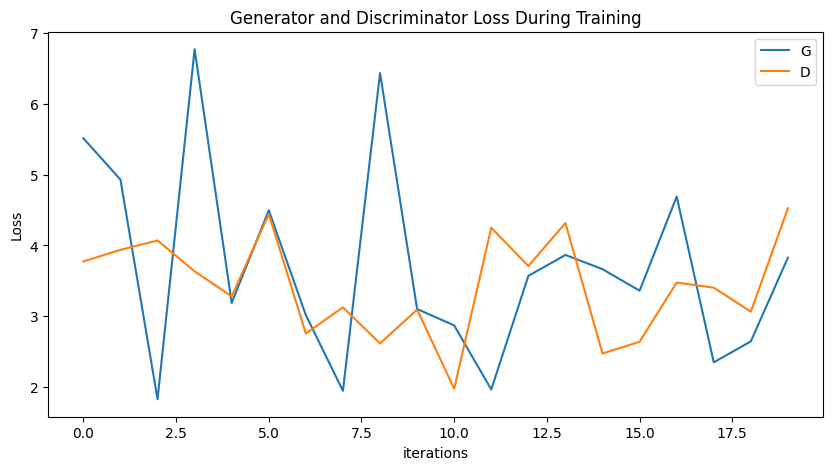

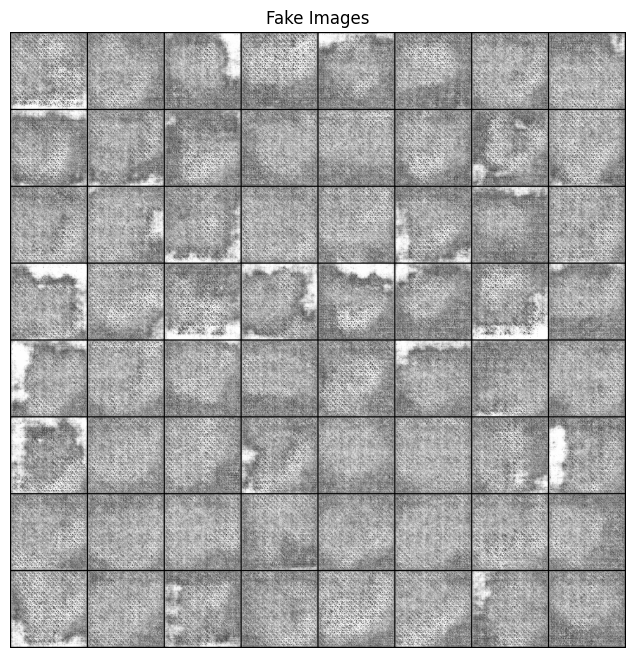

In [12]:
os.makedirs(save_dir, exist_ok=True)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # ===================== Train the discriminator =====================
        DNet.zero_grad()
        
        # Real images
        real_images = add_noise(images)
        real_labels = torch.full((images.size(0),), 1, dtype=torch.float, device=device)
        real_output, real_class_output = DNet(real_images)
        d_loss_real = criterion(real_output, real_labels) + classCriterion(real_class_output, labels)
        d_loss_real.backward()
        real_score = real_output.mean().item()
        
        # Fake images
        noise = torch.randn(images.size(0), nz, 1, 1, device=device)
        noisy_labels = torch.randint(0, 3, (images.size(0),), device=device)
        fake_images = GNet(noise, noisy_labels)
        fake_images = add_noise(fake_images)
        fake_labels = torch.full((images.size(0),), 0, dtype=torch.float, device=device)
        fake_output, fake_class_output = DNet(fake_images.detach())
        d_loss_fake = criterion(fake_output, fake_labels) + classCriterion(fake_class_output, noisy_labels)
        d_loss_fake.backward()
        fake_score = fake_output.mean().item()
        
        d_loss = d_loss_real + d_loss_fake
        optimizerD.step()
        
        # ===================== Train the generator =====================
        GNet.zero_grad()
        fake_labels.fill_(1)  # Fake labels are real for generator cost
        fake_output, fake_class_output = DNet(fake_images)
        g_loss = criterion(fake_output, fake_labels) + classCriterion(fake_class_output, noisy_labels)
        g_loss.backward()
        optimizerG.step()
        
        # Print the loss and accuracy every few iterations
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], '
                  f'D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}, '
                  f'D(x): {real_score:.2f}, D(G(z)): {fake_score:.2f}')

    # Save losses for plotting
    disc_loss.append(d_loss.item())
    gen_loss.append(g_loss.item())

# Plot losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_loss,label="G")
plt.plot(disc_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Generating fake images
with torch.no_grad():
    noise = torch.randn(64, nz, 1, 1, device=device)
    noisy_labels = torch.randint(0, 3, (64,), device=device)
    fake_images = GNet(noise, noisy_labels).detach().cpu()
    
# Plotting fake images
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(make_grid(fake_images, padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [13]:
# Generate and save 100 fake images after completing all epochs
with torch.no_grad():
    for i in range(100):
        # Generate noise and random labels
        noise = torch.randn(1, nz, 1, 1, device=device)
        random_label = torch.randint(0, 3, (1,), device=device)
        
        # Generate fake image
        fake_image = GNet(noise, random_label).detach().cpu()[0]
        
        # Save the image
        torchvision.utils.save_image(fake_image, f"generated_images/fake_image_{i}.png")

print("100 fake images saved successfully.")


100 fake images saved successfully.
